## Importing Required Libraries

In [571]:
import pandas as pd
import numpy as np
from google.colab import files
from sklearn.preprocessing import MinMaxScaler,RobustScaler,StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA
from sklearn.svm import SVR
import math
from sklearn.ensemble import IsolationForest
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import SGDRegressor
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
sns.set_style("darkgrid")
import datetime 

## Loading Data

In [2]:
uploaded = files.upload()

Saving data_selected_final_24_4.csv to data_selected_final_24_4.csv


In [3]:
data_selected_final_24_4 = pd.read_csv('data_selected_final_24_4.csv')

## Functions

### Sliding Windows & splitting data

In [372]:
def sliding_intervals(df):
  
  # selecting intervals with window side of 500
  window = 500
  window_interval = []
  train_windows = []
  test_windows = []

  # splitting each window into train and test data sets
  test_window = int(window*0.2)
  train_window = int(window*0.8)
  for i in range(0, len(df), test_window):
    if len(df.iloc[i:i+train_window,:]) >=400:
      window_interval.append(df.iloc[i:i+window,:].reset_index(drop=True)) 
      train_windows.append(df.iloc[i:i+train_window,:].reset_index(drop=True))
      test_windows.append(df.iloc[i+train_window:i+window,:].reset_index(drop=True))
  return window_interval,train_windows, test_windows

### Feature Scaling

In [373]:
# function to scale data with robust and min-max scalers
def scale_data(X_fit,X_tras):
  scale1 = RobustScaler()
  scale2 = MinMaxScaler()
  scale = make_pipeline(scale1,scale2)
  scale.fit(X_fit)
  return scale.transform(X_tras)

# function to scale data with standard scaler
def scale_data1(X_fit,X_tras):
  scale1 = StandardScaler()
  scale = make_pipeline(scale1)
  scale.fit(X_fit)
  return scale.transform(X_tras)

# function to decompose the data into components using PCA
def Principle_component_analysis(X_fit,X_tras,a):
  pca = PCA(n_components=a)  
  X_fit = pca.fit_transform(X_fit)
  X_tras = pca.transform(X_tras)
  return X_fit,X_tras


### Metrics

In [374]:
# Function to calculate Root Mean Square Error
# where y and y_pred are actual and predicted target variables
def RMSE(y,y_pred):
  n =len(y)
  sum = 0
  for i in range(n):
    sum += math.pow((y[i]-y_pred[i]),2)
  MSE = sum/n
  RMSE = np.sqrt(MSE)
  return RMSE

In [375]:
# Function to calculate  Mean Absolute Error:
def MAE(y,y_pred):
  n =len(y)
  sum = 0
  for i in range(n):
    sum += abs(y[i]-y_pred[i])
  MAE = sum/n
  return MAE

In [376]:
# Function to calculate Mean Absolute Percentage Error:
def MAPE(y,y_pred):
  n =len(y)
  y_sum = np.sum(y)
  sum = 0
  for i in range(n):
    sum += abs(y[i]-y_pred[i])
  MAPE = (sum/y_sum)
  return MAPE

In [526]:
def metrics_final(data,y,y_pred):
  print('MAE_'+str(data)+':',MAE(y,y_pred))
  print('MAPE_'+str(data)+':',MAPE(y,y_pred))
  print('RMSE_'+str(data)+':',RMSE(y,y_pred))

### Outliers

In [377]:
# Function to remove outliers using isolation forest 
def outliers(df,a):
  outlier=IsolationForest(contamination=a)
  BTC_price = df['next_day_BTC_price'].values
  BTC_price=np.reshape(BTC_price,(-1,1))
  outlier.fit(BTC_price)
  outs=outlier.predict(BTC_price)
  df['outlier']=outs
  df_new=df.query('outlier != -1')
  df_new.drop(columns=['outlier'],inplace=True)
  return df_new

## Dummy Regressor

In [702]:
data_selected_final = data_selected_final_24_4.copy()

In [703]:
window_interval,train_windows, test_windows = sliding_intervals(data_selected_final)

In [704]:
# https://scikit-learn.org/stable/modules/generated/sklearn.dummy.DummyRegressor.html

DuRegressor = DummyRegressor(strategy="quantile",quantile=0.75)

train_metric_MAE = []
train_metric_RMSE = []
train_metric_MAPE = []
test_metric_MAE = []
test_metric_RMSE = []
test_metric_MAPE = []
start_date = []
end_date = []
Date=[]
y_actual = []
y_pred = []

for i in range(len(train_windows)):
  #train_window_II = outliers(train_windows[i],0.3)
  train_window_II = train_windows[i]
  test_window_II = test_windows[i]
  x_train_windows = train_window_II.iloc[:,1:-1]
  y_train_windows = train_window_II.iloc[:,-1:]
  x_test_windows = test_window_II.iloc[:,1:-1]
  y_test_windows = test_window_II.iloc[:,-1:]
  Date.extend(np.ravel(test_window_II['Date']))
  y_actual.extend(np.ravel(y_test_windows))

  x_train_windows_scaled = scale_data1(x_train_windows,x_train_windows)
  x_test_windows_scaled = scale_data1(x_train_windows,x_test_windows)
  
  DuRegressor.fit(x_train_windows_scaled,y_train_windows)

  y_train_pred_DuReg = DuRegressor.predict(x_train_windows_scaled)
  y_test_pred_DuReg = DuRegressor.predict(x_test_windows_scaled)
  y_pred.extend(np.ravel(y_test_pred_DuReg))
  
  train_metric_MAE.append(MAE(np.ravel(y_train_windows),np.ravel(y_train_pred_DuReg)))
  train_metric_RMSE.append(RMSE(np.ravel(y_train_windows),np.ravel(y_train_pred_DuReg)))
  train_metric_MAPE.append(MAPE(np.ravel(y_train_windows),np.ravel(y_train_pred_DuReg)))

  test_metric_MAE.append(MAE(np.ravel(y_test_windows),np.ravel(y_test_pred_DuReg)))
  test_metric_RMSE.append(RMSE(np.ravel(y_test_windows),np.ravel(y_test_pred_DuReg)))
  test_metric_MAPE.append(MAPE(np.ravel(y_test_windows),np.ravel(y_test_pred_DuReg)))

  start_date.append(train_windows[i]['Date'][0])
  end_date.append(test_windows[i]['Date'][len(test_windows[i]['Date'])-1])


In [705]:
DuReg_metrics= pd.DataFrame({'start_date':start_date,'end_date':end_date,'mae_train':train_metric_MAE,
                              'rmse_train':train_metric_RMSE,
                              'mape_train':train_metric_MAPE,
                              'mae_test':test_metric_MAE,
                              'rmse_test':test_metric_RMSE,
                              'mape_test':test_metric_MAPE
                              })

In [706]:
pd.DataFrame(DuReg_metrics.iloc[:,2:].mean())

,0
mae_train,4225.034348
rmse_train,5040.351702
mape_train,0.406494
mae_test,5334.438756
rmse_test,6011.241409
mape_test,0.402445


In [707]:
df_predictions = pd.DataFrame({'Date':Date,'y_actual':y_actual,'y_pred':y_pred})
df_predictions.index = df_predictions['Date']
df_predictions.drop(['Date'],axis=1,inplace=True)
df_predictions.index = pd.to_datetime(df_predictions.index)

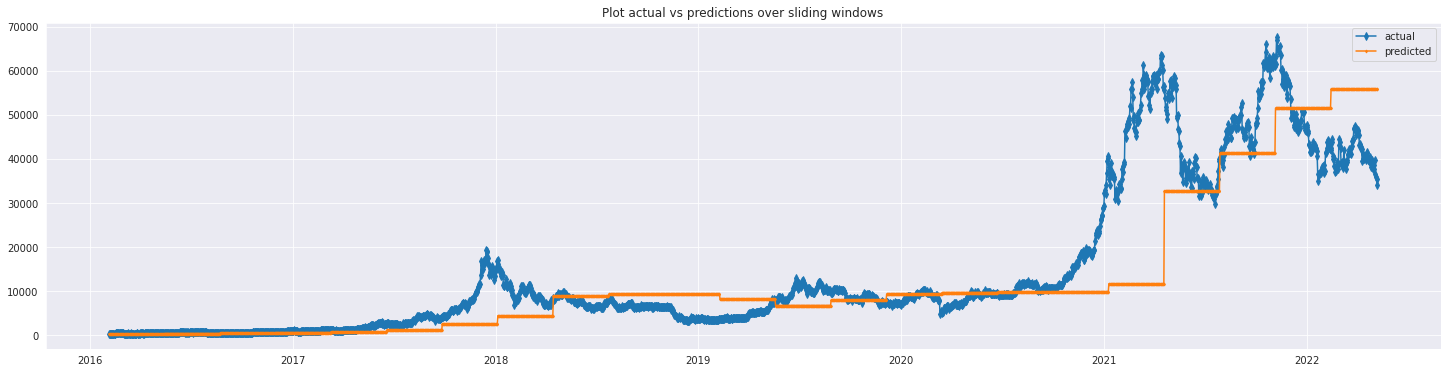

In [708]:
# plotting model performance on seen and unseen data
plt.figure(figsize=(25,6))
plt.plot(df_predictions['y_actual'],  label = "actual",marker='d',markersize=5)
plt.plot(df_predictions['y_pred'],  label = "predicted",marker='d',markersize=2)
plt.title('Plot actual vs predictions over sliding windows')
#plt.xlim(1600,)
plt.legend()
plt.show()

## Support Vector Machine Regressor

In [610]:
SVRegressor=SVR(kernel= 'linear', C= 1e+4)

train_metric_MAE = []
train_metric_RMSE = []
train_metric_MAPE = []
test_metric_MAE = []
test_metric_RMSE = []
test_metric_MAPE = []
start_date = []
end_date = []
Date = []
y_actual = []
y_pred = []

for i in range(len(train_windows)):
  train_window_II = train_windows[i]
  test_window_II = test_windows[i]
  x_train_windows = train_window_II.iloc[:,1:-1]
  y_train_windows = train_window_II.iloc[:,-1:]
  x_test_windows = test_window_II.iloc[:,1:-1]
  y_test_windows = test_window_II.iloc[:,-1:]
  Date.extend(np.ravel(test_window_II['Date']))
  y_actual.extend(np.ravel(y_test_windows))

  x_train_windows_scaled = scale_data1(x_train_windows,x_train_windows)
  x_test_windows_scaled = scale_data1(x_train_windows,x_test_windows)

  SVRegressor.fit(x_train_windows_scaled,np.ravel(y_train_windows))

  y_train_pred_SVM = SVRegressor.predict(x_train_windows_scaled)
  y_test_pred_SVM = SVRegressor.predict(x_test_windows_scaled)
  y_pred.extend(np.ravel(y_test_pred_SVM))
  
  train_metric_MAE.append(MAE(np.ravel(y_train_windows),np.ravel(y_train_pred_SVM)))
  train_metric_RMSE.append(RMSE(np.ravel(y_train_windows),np.ravel(y_train_pred_SVM)))
  train_metric_MAPE.append(MAPE(np.ravel(y_train_windows),np.ravel(y_train_pred_SVM)))

  test_metric_MAE.append(MAE(np.ravel(y_test_windows),np.ravel(y_test_pred_SVM)))
  test_metric_RMSE.append(RMSE(np.ravel(y_test_windows),np.ravel(y_test_pred_SVM)))
  test_metric_MAPE.append(MAPE(np.ravel(y_test_windows),np.ravel(y_test_pred_SVM)))

  start_date.append(train_windows[i]['Date'][0])
  end_date.append(test_windows[i]['Date'][len(test_windows[i]['Date'])-1])


In [611]:
SVM_metrics= pd.DataFrame({'start_date':start_date,'end_date':end_date,'mae_train':train_metric_MAE,
                              'rmse_train':train_metric_RMSE,
                              'mape_train':train_metric_MAPE,
                              'mae_test':test_metric_MAE,
                              'rmse_test':test_metric_RMSE,
                              'mape_test':test_metric_MAPE
                              })

In [612]:
SVM_metrics.tail(5)

,start_date,end_date,mae_train,rmse_train,mape_train,mae_test,rmse_test,mape_test
18,2019/12/06,2021/04/18,265.084477,451.937407,0.023227,1967.682231,2507.364538,0.040310
19,2020/03/15,2021/07/27,604.371494,1123.371439,0.028072,1534.657452,2012.452361,0.037940
20,2020/06/23,2021/11/04,903.951081,1467.258991,0.030551,1448.798150,1888.744636,0.028849
21,2020/10/01,2022/02/12,1206.317470,1721.513130,0.030530,1274.021154,1789.164687,0.026248
22,2021/01/09,2022/05/07,1359.106411,1850.695507,0.028914,1049.519453,1414.300879,0.025632


In [613]:
pd.DataFrame(SVM_metrics.iloc[:,2:].mean())

,0
mae_train,296.164891
rmse_train,474.476325
mape_train,0.027204
mae_test,472.807837
rmse_test,650.601715
mape_test,0.029546


In [614]:
df_predictions = pd.DataFrame({'Date':Date,'y_actual':y_actual,'y_pred':y_pred})
df_predictions.index = df_predictions['Date']
df_predictions.drop(['Date'],axis=1,inplace=True)
df_predictions.index = pd.to_datetime(df_predictions.index)

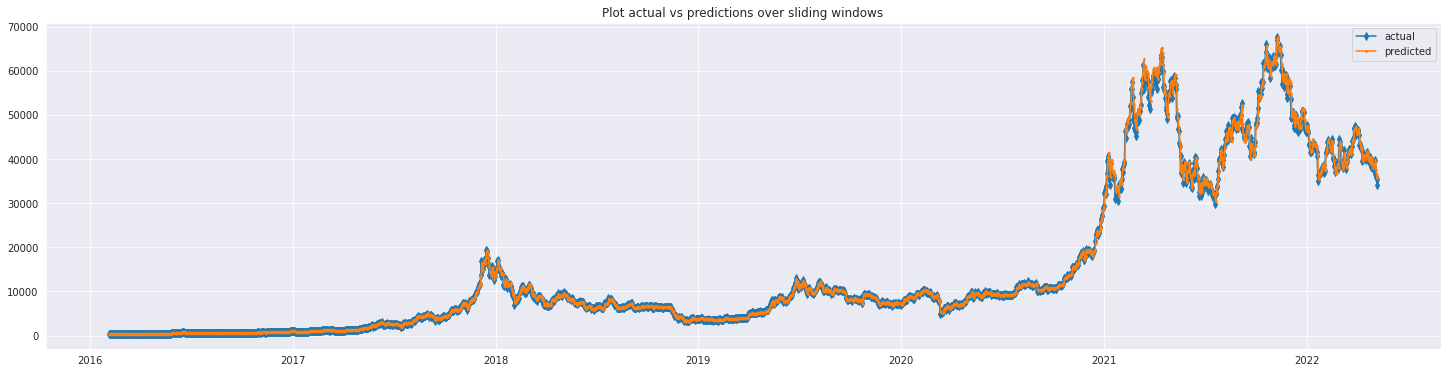

In [615]:
# plotting model performance on seen and unseen data
plt.figure(figsize=(25,6))
plt.plot(df_predictions['y_actual'],  label = "actual",marker='d',markersize=5)
plt.plot(df_predictions['y_pred'],  label = "predicted",marker='d',markersize=2)
plt.title('Plot actual vs predictions over sliding windows')
#plt.xlim(1600,)
plt.legend()
plt.show()

In [616]:
data_selected_final = data_selected_final_24_4.copy().iloc[-1095:,:]
train_split = int(len(data_selected_final)*80/100)
date = np.ravel(data_selected_final.iloc[:,:1])
X_train = data_selected_final.iloc[:,1:-1][:train_split]
Y_train= data_selected_final.iloc[:,-1:][:train_split]
X_test = data_selected_final.iloc[:,1:-1][train_split:]
Y_test = data_selected_final.iloc[:,-1:][train_split:]

X_train_scaled = scale_data1(X_train,X_train)
X_test_scaled = scale_data1(X_train,X_test)

SVRegressor.fit(X_train_scaled,np.ravel(Y_train))

Y_train_pred_SVM = SVRegressor.predict(X_train_scaled)
Y_test_pred_SVM = SVRegressor.predict(X_test_scaled)
Y_actual = np.concatenate((np.ravel(Y_train),np.ravel(Y_test)))
Y_pred = np.concatenate((np.ravel(Y_train_pred_SVM),np.ravel(Y_test_pred_SVM)))


In [617]:
df_predictions_final = pd.DataFrame({'Date':date,'Y_actual':Y_actual,'Y_pred':Y_pred})
df_predictions_final.index = df_predictions_final['Date']
df_predictions_final.drop(['Date'],axis=1,inplace=True)
df_predictions_final.index = pd.to_datetime(df_predictions_final.index)

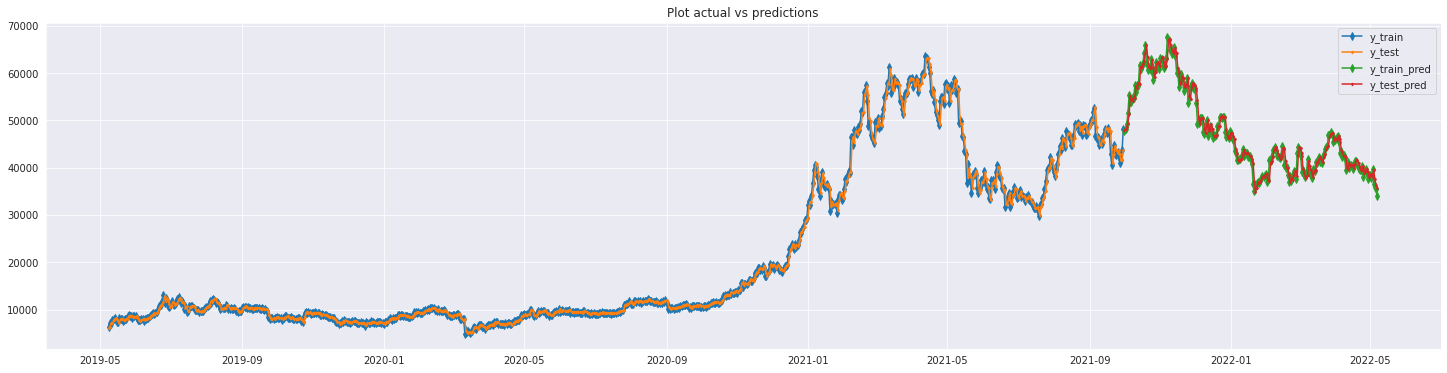

In [634]:
plt.figure(figsize=(25,6))
plt.plot(df_predictions_final['Y_actual'][:train_split],  label = "y_train",marker='d',markersize=5)
plt.plot(df_predictions_final['Y_pred'][:train_split],  label = "y_test",marker='d',markersize=2)
plt.plot(df_predictions_final['Y_actual'][train_split:],  label = "y_train_pred",marker='d',markersize=5)
plt.plot(df_predictions_final['Y_pred'][train_split:],  label = "y_test_pred",marker='d',markersize=2)
plt.title('Plot actual vs predictions')
plt.legend()
plt.show()

In [619]:
metrics_final('train',df_predictions_final['Y_actual'][:train_split],df_predictions_final['Y_pred'][:train_split])

MAE_train: 635.2037567320523
MAPE_train: 0.03020512376115531
RMSE_train: 1145.1043273071302


In [620]:
metrics_final('test',df_predictions_final['Y_actual'][train_split:],df_predictions_final['Y_pred'][train_split:])

MAE_test: 1167.069069187784
MAPE_test: 0.024696265416110984
RMSE_test: 1610.6387458459733


## Linear Regression with SGD optimizer

In [560]:
SGDreg = SGDRegressor(max_iter=1e+07,loss ='squared_epsilon_insensitive' ,tol=1e-3,learning_rate='adaptive',eta0 =0.01)

train_metric_MAE = []
train_metric_RMSE = []
train_metric_MAPE = []
test_metric_MAE = []
test_metric_RMSE = []
test_metric_MAPE = []
start_date = []
end_date = []
Date = []
y_actual = []
y_pred = []

for i in range(len(train_windows)):
  #train_window_II = outliers(train_windows[i],0.3)
  train_window_II = train_windows[i]
  test_window_II = test_windows[i]
  x_train_windows = train_window_II.iloc[:,1:-1]
  y_train_windows = train_window_II.iloc[:,-1:]
  x_test_windows = test_window_II.iloc[:,1:-1]
  y_test_windows = test_window_II.iloc[:,-1:]
  Date.extend(np.ravel(test_window_II['Date']))
  y_actual.extend(np.ravel(y_test_windows))

  x_train_windows_scaled = scale_data1(x_train_windows,x_train_windows)
  x_test_windows_scaled = scale_data1(x_train_windows,x_test_windows)
  
  SGDreg.fit(x_train_windows_scaled,np.ravel(y_train_windows))

  y_train_pred_SGDr = SGDreg.predict(x_train_windows_scaled)
  y_test_pred_SGDr = SGDreg.predict(x_test_windows_scaled)
  y_pred.extend(np.ravel(y_test_pred_SGDr))
  
  train_metric_MAE.append(MAE(np.ravel(y_train_windows),np.ravel(y_train_pred_SGDr)))
  train_metric_RMSE.append(RMSE(np.ravel(y_train_windows),np.ravel(y_train_pred_SGDr)))
  train_metric_MAPE.append(MAPE(np.ravel(y_train_windows),np.ravel(y_train_pred_SGDr)))

  test_metric_MAE.append(MAE(np.ravel(y_test_windows),np.ravel(y_test_pred_SGDr)))
  test_metric_RMSE.append(RMSE(np.ravel(y_test_windows),np.ravel(y_test_pred_SGDr)))
  test_metric_MAPE.append(MAPE(np.ravel(y_test_windows),np.ravel(y_test_pred_SGDr)))

  start_date.append(train_windows[i]['Date'][0])
  end_date.append(test_windows[i]['Date'][len(test_windows[i]['Date'])-1])

In [561]:
SGDr_metrics= pd.DataFrame({'start_date':start_date,'end_date':end_date,'mae_train':train_metric_MAE,
                              'rmse_train':train_metric_RMSE,
                              'mape_train':train_metric_MAPE,
                              'mae_test':test_metric_MAE,
                              'rmse_test':test_metric_RMSE,
                              'mape_test':test_metric_MAPE
                              })

In [562]:
SGDr_metrics.tail(5)

,start_date,end_date,mae_train,rmse_train,mape_train,mae_test,rmse_test,mape_test
18,2019/12/06,2021/04/18,274.571785,454.784003,0.024058,2580.805668,3180.531452,0.052871
19,2020/03/15,2021/07/27,693.204275,1185.490786,0.032198,1683.049519,2141.729633,0.041608
20,2020/06/23,2021/11/04,952.736768,1476.677238,0.032200,1793.362739,2302.617073,0.035710
21,2020/10/01,2022/02/12,1233.339281,1718.819368,0.031214,1275.705240,1802.838008,0.026283
22,2021/01/09,2022/05/07,1385.601273,1850.919896,0.029478,1073.188463,1430.145476,0.026210


In [563]:
pd.DataFrame(SGDr_metrics.iloc[:,2:].mean())

,0
mae_train,310.139394
rmse_train,478.344558
mape_train,0.028947
mae_test,561.593908
rmse_test,749.132076
mape_test,0.035950


In [564]:
df_predictions = pd.DataFrame({'Date':Date,'y_actual':y_actual,'y_pred':y_pred})
df_predictions.index = df_predictions['Date']
df_predictions.drop(['Date'],axis=1,inplace=True)
df_predictions.index = pd.to_datetime(df_predictions.index)

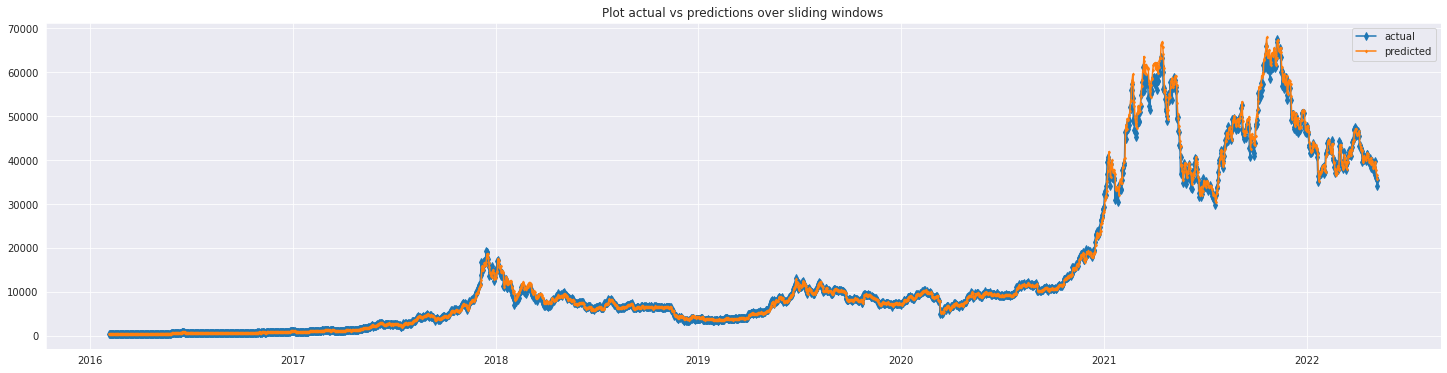

In [565]:
# plotting model performance on seen and unseen data
plt.figure(figsize=(25,6))
plt.plot(df_predictions['y_actual'],  label = "actual",marker='d',markersize=5)
plt.plot(df_predictions['y_pred'],  label = "predicted",marker='d',markersize=2)
plt.title('Plot actual vs predictions over sliding windows')
#plt.xlim(1600,)
plt.legend()
plt.show()

In [566]:
data_selected_final = data_selected_final_24_4.copy().iloc[-1095:,:]
train_split = int(len(data_selected_final)*80/100)
date = np.ravel(data_selected_final.iloc[:,:1])
X_train = data_selected_final.iloc[:,1:-1][:train_split]
Y_train= data_selected_final.iloc[:,-1:][:train_split]
X_test = data_selected_final.iloc[:,1:-1][train_split:]
Y_test = data_selected_final.iloc[:,-1:][train_split:]

X_train_scaled = scale_data1(X_train,X_train)
X_test_scaled = scale_data1(X_train,X_test)

SGDreg.fit(X_train_scaled,np.ravel(Y_train))

Y_train_pred_SGDr = SGDreg.predict(X_train_scaled)
Y_test_pred_SGDr = SGDreg.predict(X_test_scaled)
Y_actual = np.concatenate((np.ravel(Y_train),np.ravel(Y_test)))
Y_pred = np.concatenate((np.ravel(Y_train_pred_SGDr),np.ravel(Y_test_pred_SGDr)))


In [567]:
df_predictions_final = pd.DataFrame({'Date':date,'Y_actual':Y_actual,'Y_pred':Y_pred})
df_predictions_final.index = df_predictions_final['Date']
df_predictions_final.drop(['Date'],axis=1,inplace=True)
df_predictions_final.index = pd.to_datetime(df_predictions_final.index)

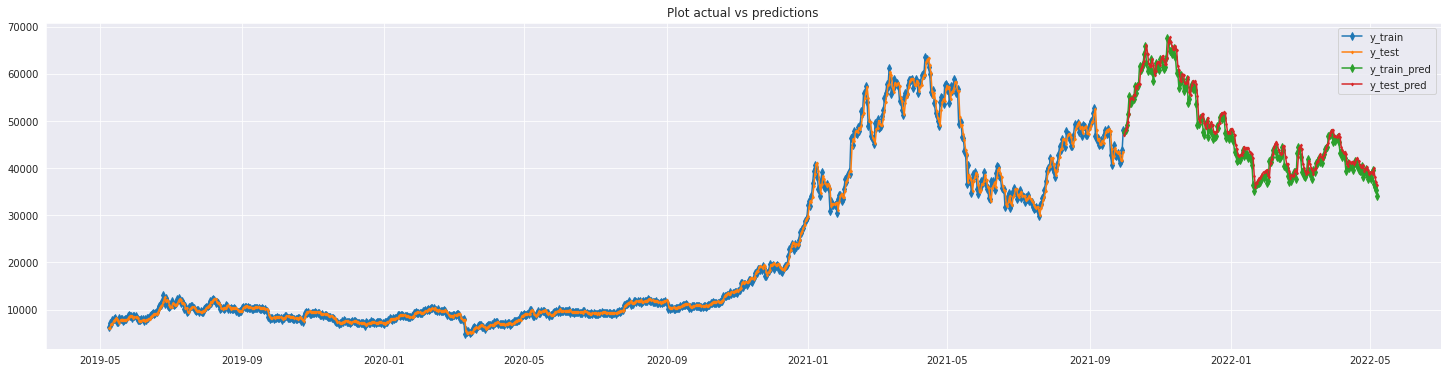

In [568]:
import datetime 
plt.figure(figsize=(25,6))
plt.plot(df_predictions_final['Y_actual'][:train_split],  label = "y_train",marker='d',markersize=5)
plt.plot(df_predictions_final['Y_pred'][:train_split],  label = "y_test",marker='d',markersize=2)
plt.plot(df_predictions_final['Y_actual'][train_split:],  label = "y_train_pred",marker='d',markersize=5)
plt.plot(df_predictions_final['Y_pred'][train_split:],  label = "y_test_pred",marker='d',markersize=2)
plt.title('Plot actual vs predictions')
plt.legend()
plt.show()

In [569]:
metrics_final('train',df_predictions_final['Y_actual'][:train_split],df_predictions_final['Y_pred'][:train_split])

MAE_train: 669.2553006321359
MAPE_train: 0.031824338205118846
RMSE_train: 1161.1875892790472


In [570]:
metrics_final('test',df_predictions_final['Y_actual'][train_split:],df_predictions_final['Y_pred'][train_split:])

MAE_test: 1446.2447439820069
MAPE_test: 0.030603881978375182
RMSE_test: 1890.7161367343826
